In [45]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from torch.optim import lr_scheduler
from sklearn import preprocessing
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn import tree
import rasterio as rio
import pandas as pd
import numpy as np
import importlib
import sklearn
import random
import pickle
import torch
import math
import copy
import os

import resnet18
importlib.reload(resnet18)
from helpers import *

import warnings
warnings.filterwarnings('ignore')

In [46]:
dta = pd.read_csv("./us_migration.csv")
dta.head()

,sending,sending_citizen_unspecified,sending_citizenship_unknown,sending_household_not_owned,sending_household_owned,sending_household_owned_unknown,sending_indigeneity,sending_internet,sending_internet_unknown,sending_marriage_unknown,...,sending_unknown_employment_status,sending_unknown_indigeneity,sending_unpaid_worker,sending_urban,sending_weighted_avg_income,sending_weighted_avg_income_abroad,sending_weighted_avg_no_income_abroad,sending_weighted_avg_unknown_income_abroad,sending_widowed,US_MIG_05_10
0,10001,1134.995083,243.827586,1178.209016,1106.832815,736.562500,918.960526,2111.233685,347.698113,576.362069,...,1218.357143,840.339623,0,1597.239059,1124.200953,768.788518,1213.505104,1931.825000,460.430041,961
1,10002,917.067746,600.000000,1274.160656,795.118020,-1.000000,-1.000000,1988.103175,459.166667,342.800000,...,535.750000,576.379310,0,-1.000000,908.782316,720.767123,929.317603,845.567568,745.377359,154
2,10003,637.977315,557.150000,729.454795,610.791414,468.392857,584.454545,1310.462428,514.312500,3800.000000,...,540.000000,629.215385,0,-1.000000,628.585520,486.116034,738.533015,-1.000000,276.569767,905
3,10004,1178.378744,1678.562500,1560.244328,1084.109969,785.742857,1165.943463,2109.431851,1043.500000,549.695652,...,771.400000,694.579439,0,1436.934837,1173.751889,861.385645,1219.547797,1643.137255,741.363985,225
4,10005,2231.128863,2916.538705,2104.943216,2278.834178,2353.519005,2527.268790,3075.771459,1941.578834,650.206897,...,1531.622086,2064.311411,0,2319.113608,2230.022635,1672.340116,2273.630651,3946.180995,1241.236982,1071


<AxesSubplot:>

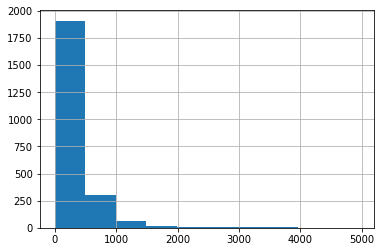

In [47]:
dta['US_MIG_05_10'].hist()

In [4]:
d = dataLoader("./final_pics", "./us_migration.csv")

In [58]:
x_train, y_train, x_val, y_val = d.train_val_split(split = .80)

In [69]:
#y - 'number_moved'
#x - 'everything else that is or can be represented as a float.'

####### Build and fit the Model
lr = 1e-5
batchSize = 10
model = resnet18.resnet18(outDim = batchSize)

In [70]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [71]:
def train_model(model, criterion, optimizer, lr, batchSize, num_epochs):

    losses = []
    maes = []
    best_mae = 100000000
    i_to_print = torch.tensor([0,1,2,3,4])

    for t in range(num_epochs):

        for phase in ['train', 'val']:

            train_is = [i for i in range(0, len(y_train))]
            val_is = [i for i in range(0, len(y_val))]

            if phase == 'train':

                running_loss = 0
                running_mae = 0
                count = 0

                while len(train_is) > batchSize:

                    # print("train_is length: ", len(train_is))

                    #Batches
                    # batchObs = random.sample(range(0, len(y_train)), batchSize)
                    batchObs = random.sample(train_is, batchSize)
                    train_is = [i for i in train_is if i not in batchObs]
                    # print(batchObs)
                    modelX = [x_train[i] for i in batchObs]
                    modelX = torch.tensor(list(modelX), requires_grad = True, dtype = torch.float32)
                    modely = torch.tensor([y_train[i] for i in batchObs], dtype = torch.float32)  # MADE A CHANGE HERE 

                    with torch.set_grad_enabled(phase == 'train'):

                        y_pred = model(modelX, t)
                        # print(y_pred)
                        
                        loss = criterion(y_pred, modely) 
                        # print(loss.item())

                        running_loss += loss.item()# * batchSize
                        
                        count += 1

                        
                        # Zero gradients, perform a backward pass, and update the weights.
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                
                    epoch_mae = mae(y_pred, modely).item()
                    running_mae += epoch_mae# * batchSize

                print("EPOCH: ", t)
                print("    TRAIN    Loss:   ", str(running_loss / count), "     MAE:   ", running_mae / count)
                    # print("    Train Preds:     ", torch.index_select(y_pred, 0, i_to_print))
                    # print("    Train True:       ", torch.index_select(modely, 0, i_to_print))

            

            if phase == 'val':

                #Batches
                batchObs = random.sample(range(0, len(y_train)), batchSize)
                modelX = [x_train[i] for i in batchObs]
                modelX = torch.tensor(list(modelX), requires_grad = True, dtype = torch.float32)
                modely = torch.tensor([y_train[i] for i in batchObs], dtype = torch.float32)  # MADE A CHANGE HERE 
                
                # Perform evaluations of the batch predictions
                y_pred = model(modelX, t)
                
                loss = criterion(y_pred, modely)  
                epoch_mae = mae(y_pred, modely).item()
                print("    VAL      Loss:   ", loss.item(), "     MAE:   ", epoch_mae)

                if epoch_mae < best_mae:
                    
                    best_mae = epoch_mae
                    best_model_wts = copy.deepcopy(model.state_dict())
                    model_name = './models/test_Epoch' + str(t) + '.sav'
                    pickle.dump(model, open(model_name, 'wb'))

                losses.append(loss.item())
                maes.append(epoch_mae)

            
        # if t % 2 == 0:
        #     lr *= .1
        #     print("Decayed LR to ", str(lr))

        print("\n")

    print("TRAINING COMPLETE")
    print("Best MAE: ", best_mae)

    # print(best_model_wts)

    # return model.load_state_dict(best_model_wts)
    return best_model_wts, losses, maes, y_pred, modely

In [72]:
num_epochs = 100

best_model_wts, losses, maes, ypreds, ytrue = train_model(model, criterion, optimizer, lr, batchSize, num_epochs)

EPOCH:  0
    TRAIN    Loss:    2376346.5070945946      MAE:    299.82097101984795
    VAL      Loss:    5348946.0      MAE:    480.88397216796875


EPOCH:  1
    TRAIN    Loss:    2375267.6773015205      MAE:    290.60122969343854
    VAL      Loss:    472896.6875      MAE:    168.2992706298828


EPOCH:  2
    TRAIN    Loss:    2639246.4375844593      MAE:    311.43568436906145
    VAL      Loss:    2839712.5      MAE:    361.9762878417969


EPOCH:  3
    TRAIN    Loss:    2570183.5521537163      MAE:    295.62432292216533
    VAL      Loss:    586113.3125      MAE:    189.861572265625


EPOCH:  4
    TRAIN    Loss:    2519625.028399493      MAE:    288.4671057417586
    VAL      Loss:    4767064.0      MAE:    415.38421630859375


EPOCH:  5
    TRAIN    Loss:    2462290.44375      MAE:    280.9442604683541
    VAL      Loss:    1954082.5      MAE:    305.01513671875


EPOCH:  6
    TRAIN    Loss:    2406402.8690033783      MAE:    273.98965227281724
    VAL      Loss:    3601814.0   

KeyboardInterrupt: 

In [436]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [437]:
def pred_dataset(x_val, model, batch_size, y_val):
    preds, true_vals = [], []
    lst = [i for i in range(0, len(x_val))]
    batches = [lst[i:i+batch_size] for i in range(0, len(lst), batch_size)]
    batches = [i for i in batches if len(i) == batch_size]
    n = len(batches)
    for subset in range(0, n):
        cur_xval = [x_val[i] for i in batches[subset]]
        modelX = torch.tensor(list(cur_xval), requires_grad = True, dtype = torch.float32)
        cur_preds = model(modelX, 400)
        preds.append(list(cur_preds.detach().numpy()))
        true_vals.append([y_val[i] for i in batches[subset]])

        print("Done with batch ", str(subset), " out of ", str(n))

    true_vals = [item for sublist in true_vals for item in sublist]
    preds = [item for sublist in preds for item in sublist]

    to_ret = pd.DataFrame()
    to_ret['id'] = [i for i in range(0, len(true_vals))]
    to_ret['pred'] = preds
    to_ret['true_val'] = true_vals
    
    return to_ret

In [439]:
preds_df = pred_dataset(x_val, model, 50, y_val)
preds_df.head()

Done with batch  0  out of  9
Done with batch  1  out of  9
Done with batch  2  out of  9
Done with batch  3  out of  9
Done with batch  4  out of  9
Done with batch  5  out of  9
Done with batch  6  out of  9
Done with batch  7  out of  9
Done with batch  8  out of  9


,id,pred,true_val
0,0,253.387497,84
1,1,282.059753,619
2,2,132.223969,99
3,3,234.058350,335
4,4,119.194290,242


In [440]:
allocation_error = abs((sum(preds_df['true_val']) - sum(preds_df['pred'])) / len(preds_df['pred']))
allocation_error

145.3001728301578

In [441]:
quantity_error = abs(sum(preds_df['true_val']) - sum(preds_df['pred']))
quantity_error

65385.077773571014

In [442]:
mae = mean_absolute_error(preds_df['true_val'], preds_df['pred'])
mae

220.56919460614523

In [443]:
mape = mean_absolute_percentage_error(preds_df['true_val'], preds_df['pred'])
mape

1.1930450050956074e+16

In [444]:
r2 = r2_score(preds_df['true_val'], preds_df['pred'])
r2

-0.2219833236569433

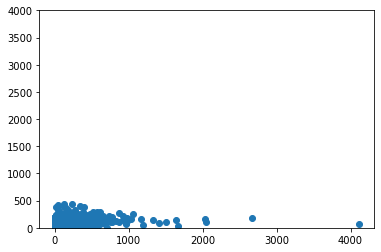

In [447]:
plt.scatter(preds_df['true_val'], preds_df['pred'])
plt.ylim([0, 4000])
plt.savefig("./model_plots/socialSig.png")